In [3]:
import torch
import pandas as pd
from torch_geometric.nn import HeteroConv, Linear, SAGEConv, GATConv, to_hetero
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.profile import count_parameters

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [5]:
import itertools

ATTRIBUTE_ENCODING_LENGTH = 10
EXTRA_NODE_TYPES = ["order", "customer"]
NUM_CATEGORIES = 32
NUM_SIZES = 29
NUM_COLORS = 642

pairs = list(itertools.product(range(NUM_CATEGORIES), range(NUM_SIZES)))
CATGORY_SIZE_INDEX = {pair: i for i, pair in enumerate(pairs)}


In [6]:
class IdentityEncoder:
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)


In [7]:
def load_node_csv(path, index_col, encoders=None, **kwargs):
    df = pd.read_csv(path, index_col=index_col, **kwargs)
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

In [8]:
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping,
                  attr_encoders=None,label_encoders = None ,**kwargs):
    df = pd.read_csv(path, **kwargs)

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    edge_attr = None
    edge_label = None

    if attr_encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in attr_encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)
    if label_encoders is not None:
        edge_labels = [encoder(df[col]) for col, encoder in label_encoders.items()]
        edge_label = torch.cat(edge_labels, dim=-1)

    return edge_index, edge_attr, edge_label

In [9]:
path = "data/task2/"

In [10]:
customer_encoders = {col_name : IdentityEncoder(dtype=torch.float32) for col_name in ["n_orders","n_not_returned","n_partial_returned","n_fully_returned","n_products"]}
order_encoders = {col_name : IdentityEncoder(dtype=torch.float32) for col_name in ["n_products"]}
product_encoders = {col_name : IdentityEncoder(dtype=torch.float32) for col_name in ["total_count","return_1","return1_rate"]}
customer_x, customer_mapping = load_node_csv(path + 'customer_node_attributes.csv', index_col='customer', encoders=customer_encoders)
order_x, order_mapping = load_node_csv(path + 'order_node_attributes.csv', index_col='order', encoders=order_encoders)
product_x, product_mapping = load_node_csv(path + 'product_node_attributes.csv', index_col='product', encoders=product_encoders)


In [11]:
customer_order_edge_attr_encoders = {col_name : IdentityEncoder(dtype=torch.float32) for col_name in ["n_products"]}
customer_order_edge_label_encoders = {"label" : IdentityEncoder(torch.long)}
order_product_edge_attr_encoders = {col_name : IdentityEncoder(dtype=torch.long) for col_name in ["color", "size","train_masks","valid_masks","test_masks"]}
order_product_edge_label_encoders = {"label" : IdentityEncoder(torch.long)}

customer_order_edge_index, customer_order_edge_attr, customer_order_edge_label = load_edge_csv(path + 'customer_edgelist.csv',
                                                                                               'customer', customer_mapping,
                                                                                               'order', order_mapping,
                                                                                               attr_encoders=customer_order_edge_attr_encoders)
order_product_edge_index, order_product_edge_attr, order_product_edge_label = load_edge_csv(path + 'order_edgelist.csv',
                                                                                            'order', order_mapping,
                                                                                            'product', product_mapping,
                                                                                            attr_encoders=order_product_edge_attr_encoders,
                                                                                            label_encoders=order_product_edge_label_encoders)

In [12]:
customer_order_edge_attr

tensor([[2.],
        [3.],
        [2.],
        ...,
        [9.],
        [1.],
        [2.]])

In [13]:
from torch_geometric.data import HeteroData

data = HeteroData()

customer_mapping = []
order_mapping = []
item_mapping = []

data['order'].x = order_x
data['product'].x = product_x
data['customer'].x = customer_x
data['customer', 'order'].edge_index = customer_order_edge_index
data['customer', 'order'].edge_attr = customer_order_edge_attr
data['customer', 'order'].edge_label = customer_order_edge_label

data['order',  'product'].edge_index = order_product_edge_index
data['order',  'product'].edge_attr = order_product_edge_attr[:,:-3]
data['order',  'product'].edge_mask = order_product_edge_attr[:,-3:]
data['order',  'product'].edge_label = order_product_edge_label

data = T.ToUndirected()(data)
data = data.to(device)
del data['order', 'rev_to', 'customer'].edge_label
del data['product', 'rev_to', 'order'].edge_label
print(data)

HeteroData(
  order={ x=[849185, 1] },
  product={ x=[58415, 3] },
  customer={ x=[342038, 5] },
  (customer, to, order)={
    edge_index=[2, 849185],
    edge_attr=[849185, 1],
  },
  (order, to, product)={
    edge_index=[2, 2666262],
    edge_attr=[2666262, 2],
    edge_mask=[2666262, 3],
    edge_label=[2666262, 1],
  },
  (order, rev_to, customer)={
    edge_index=[2, 849185],
    edge_attr=[849185, 1],
  },
  (product, rev_to, order)={
    edge_index=[2, 2666262],
    edge_attr=[2666262, 2],
    edge_mask=[2666262, 3],
  }
)


In [14]:
c_o = data[('customer', 'order')].edge_index
o_p = data['order', 'product'].edge_index
sorted_tensor, sorted_indices = c_o[1].sort(dim=0)
i = sorted_indices[o_p[0]]
CUSTOMER_INDICES_FOR_ORDER_PRODUCT_EDGE = c_o[0][i]

In [15]:
from torch_geometric.nn import HANConv

class HAN(torch.nn.Module):
    def __init__(self, in_channels: int,
                 out_channels: int, hidden_channels=128, heads=8):
        super().__init__()
        self.han_conv = HANConv(in_channels, hidden_channels, heads=heads,
                                dropout=0.6, metadata=data.metadata())
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict=None):
        out = self.han_conv(x_dict, edge_index_dict)
        out = self.lin(out["order"])
        return out

In [16]:
from torch_geometric.utils import trim_to_layer



class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels)
        # self.conv2 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        # self.lin2  = Linear(-1, hidden_channels)
        self.conv_final = GATConv((-1, -1), out_channels, add_self_loops=False)
        self.lin_final = Linear(-1, out_channels)


    def forward(self, x, edge_index, edge_attr):

        x = self.conv1(x, edge_index,edge_attr) + self.lin1(x)
        x = x.relu()
        # x = self.conv2(x, edge_index,edge_attr) + self.lin2(x)
        # x = x.relu()
        x = self.conv_final(x, edge_index,edge_attr) + self.lin_final(x)
        return x

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)


    def forward(self, x, edge_index, edge_attr):
        print(x.shape, edge_index.shape, edge_attr.shape)
        x = self.conv1(x, edge_index).relu()
        print(x.shape)
        x = self.conv2(x, edge_index)
        print("2",x.shape)
        return x

In [17]:
import copy
# GNN + Classifier
class MyModel(torch.nn.Module):
    def __init__(self, model, embedding_dim):
        super(MyModel, self).__init__()
        self.model = model

        self.classifier1 = Linear(3*embedding_dim, 3)


    def forward(self, x, edge_index, edge_attr):

        x = copy.copy(x)
        edge_index = copy.copy(edge_index)
        edge_attr = copy.copy(edge_attr)
        output =  self.model(x, edge_index,edge_attr)
        o_p_index = edge_index[('order', 'to', 'product')]
        o_f = output["order"][o_p_index[0]]
        p_f = output["product"][o_p_index[1]]
        c_f = output["customer"][CUSTOMER_INDICES_FOR_ORDER_PRODUCT_EDGE]
        f = torch.cat([c_f,o_f,p_f],dim=-1)
        pred = self.classifier1(f)
        return pred

In [18]:
@torch.no_grad()
def init_params(n_model):
    # Initialize lazy parameters via forwarding a single batch to the model:
    output = n_model(data.x_dict, data.edge_index_dict, data.edge_attr_dict)
    return output

In [19]:
from torch.optim.lr_scheduler import ExponentialLR
embedding_dim = 16
model = GAT(hidden_channels =  32,out_channels =embedding_dim)
model = to_hetero(model, data.metadata(), aggr='sum').to(device)
# model = HAN(in_channels = -1, out_channels = 3, hidden_channels=64, heads=8).to(device)
embedded_model = MyModel(model, embedding_dim=embedding_dim).to(device)
optimizer = torch.optim.Adam(embedded_model.parameters(), lr=0.001)

output = init_params(embedded_model)

In [20]:

def train(model):
    model.train()
    optimizer.zero_grad()
    output = model(data.x_dict, data.edge_index_dict,data.edge_attr_dict
                 )
    mask = data['order', 'product'].edge_mask[:,0].bool()

    pred = F.softmax(output[mask], dim=-1)
    target = data['order', 'product'].edge_label[mask].squeeze()
    loss = F.cross_entropy(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

In [21]:
from tqdm import tqdm
@torch.no_grad()
def test(model, test_set):
    model.eval()
    output = model(data.x_dict, data.edge_index_dict,data.edge_attr_dict
                 )
    # edge_attr[:,-3] - train mask
    if test_set == "train":
        mask_index = 0
    elif test_set == "valid":
        mask_index = 1
    elif test_set == "test":
        mask_index = 2
    else:
        raise ValueError("Invalid set for testing")
    mask = data['order', 'product'].edge_mask[:,mask_index].bool()
    pred = F.softmax(output[mask], dim=-1)
    target = data['order', 'product'].edge_label[mask].squeeze()
    pred = pred.argmax(dim=-1)
    total_correct = pred.eq(target).sum().item()
    total_0 = pred.eq(0).sum().item()
    total_1 = pred.eq(1).sum().item()
    total_2 = pred.eq(2).sum().item()
    print(f"Total correct: {total_correct}, Total 0: {total_0}, Total 1: {total_1}, Total 2: {total_2}")



    return total_correct / mask.sum().item(), total_0/ mask.sum().item(), total_1/ mask.sum().item(), total_2/ mask.sum().item()

In [22]:
losses = []
train_accs = []
valid_accs = []
valid_dist = []
for epoch in range(1, 501):
    loss = train(embedded_model)
    losses.append(loss)

    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
    if epoch % 10 == 0:
        train_acc, _, _, _ = test(embedded_model, "train")
        valid_acc, z, o,t = test(embedded_model, "valid")
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        valid_dist.append([z,o,t])
        print(f"Train accuracy: {train_acc}")
        print(f"Valid accuracy: {valid_acc}")





Epoch: 01, Loss: 1.0720
Epoch: 02, Loss: 1.0706
Epoch: 03, Loss: 1.0690
Epoch: 04, Loss: 1.0673
Epoch: 05, Loss: 1.0648
Epoch: 06, Loss: 1.0614
Epoch: 07, Loss: 1.0563
Epoch: 08, Loss: 1.0487
Epoch: 09, Loss: 1.0383
Epoch: 10, Loss: 1.0261
Total correct: 966778, Total 0: 315140, Total 1: 1551235, Total 2: 8
Total correct: 205435, Total 0: 70503, Total 1: 329436, Total 2: 1
Train accuracy: 0.517995502530831
Valid accuracy: 0.5136645496824523
Epoch: 11, Loss: 1.0191
Epoch: 12, Loss: 1.0203
Epoch: 13, Loss: 1.0224
Epoch: 14, Loss: 1.0231
Epoch: 15, Loss: 1.0225
Epoch: 16, Loss: 1.0209
Epoch: 17, Loss: 1.0175
Epoch: 18, Loss: 1.0108
Epoch: 19, Loss: 0.9998
Epoch: 20, Loss: 0.9957
Total correct: 1005514, Total 0: 741105, Total 1: 1125266, Total 2: 12
Total correct: 214236, Total 0: 165474, Total 1: 234465, Total 2: 1
Train accuracy: 0.5387500850575686
Valid accuracy: 0.5356703505525829
Epoch: 21, Loss: 1.0001
Epoch: 22, Loss: 1.0008
Epoch: 23, Loss: 0.9969
Epoch: 24, Loss: 0.9894
Epoch: 25,

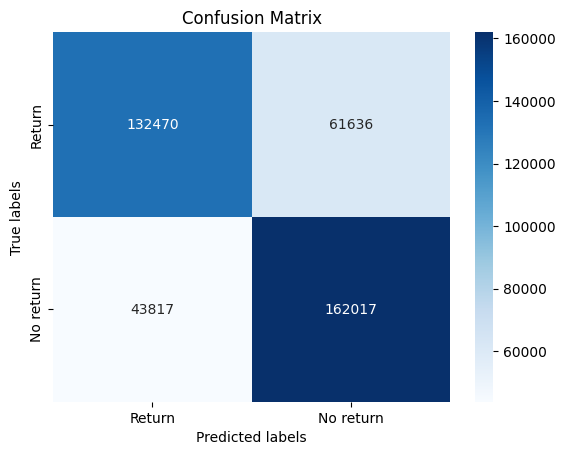

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
embedded_model.eval()
output = embedded_model(data.x_dict, data.edge_index_dict,data.edge_attr_dict
                )
mask_index = 1
mask = data['order', 'product'].edge_mask[:,mask_index].bool()
pred = F.softmax(output[mask], dim=-1)
target = data['order', 'product'].edge_label[mask].squeeze()
pred = pred.argmax(dim=-1)

ax= plt.subplot()

cfm = confusion_matrix(target.cpu().numpy(), pred.cpu().numpy(), )
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues',ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Return', 'No return']); ax.yaxis.set_ticklabels(['Return', 'No return']);
plt.savefig("cfm.png")

In [33]:
print(classification_report(target.cpu().numpy(), pred.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.75      0.68      0.72    194106
           1       0.72      0.79      0.75    205834

    accuracy                           0.74    399940
   macro avg       0.74      0.73      0.73    399940
weighted avg       0.74      0.74      0.74    399940



In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(target.cpu().numpy(), pred.cpu().numpy())

0.7347933679827682

In [35]:
from sklearn.metrics import accuracy_score

accuracy_score(target.cpu().numpy(), pred.cpu().numpy())

0.7363279491923789

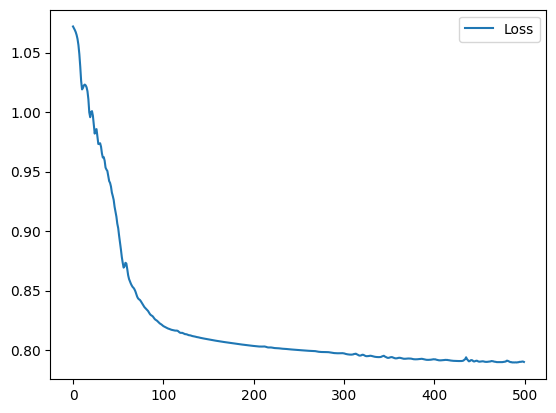

In [68]:
import matplotlib.pyplot as plt
plt.plot(losses)

plt.legend(["Loss"])
plt.savefig("loss.png")
plt.show()


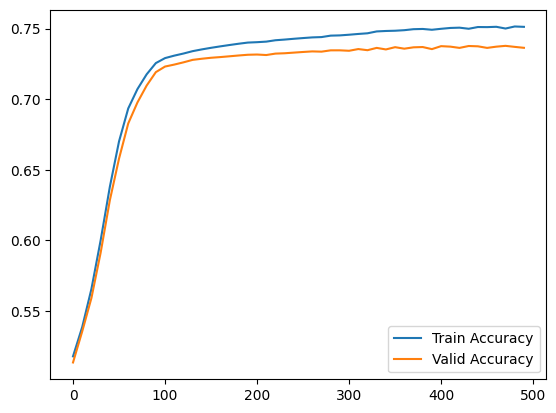

In [67]:
import numpy as np
plt.plot(train_accs)
plt.plot(valid_accs)
plt.xticks(np.arange(0, 51, 10), np.arange(0, 510, 100))  # Set the x-ticks

plt.legend(["Train Accuracy", "Valid Accuracy"])
plt.savefig("acc.png")
plt.show()


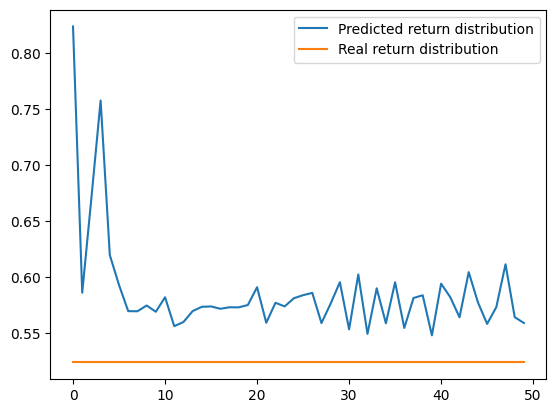

In [66]:
import numpy as np

mask_index = 0
mask = data['order', 'product'].edge_mask[:,mask_index].bool()
target = data['order', 'product'].edge_label[mask].squeeze().cpu()
valid_dist = np.array(valid_dist)
plt.plot(valid_dist[:,1])
dist = torch.bincount(target)/len(target)
plt_dist =dist.unsqueeze(1).repeat(1, 50).cpu()
# plt.plot(plt_dist[0])
plt.plot(plt_dist[1])
# plt.plot(valid_dist[:,2])
plt.legend(["Predicted return distribution", "Real return distribution"])
plt.savefig("dist.png")
plt.show()
